In [48]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
!pip install wordcloud
!pip install textblob
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

In [10]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

# Lists to store scraped data
all_reviews = []
all_data_dicts = []

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
}

# Loop over each page
for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    
    # Construct the URL for each page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    
    # Fetch the page content
    response = requests.get(url, headers=headers)
    
    # Check for a successful response
    if response.status_code != 200:
        print(f"Failed to retrieve page {i}: Status code {response.status_code}")
        continue
    
    # Parse the HTML content
    parsed_content = BeautifulSoup(response.content, 'html.parser')
    
    # Extract review texts
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        all_reviews.append(para.get_text().strip())
    
    # Extract review ratings and other stats
    for review_stats in parsed_content.find_all("div", {"class": "review-stats"}):
        rating = []
        category = []
        
        # Extract review values
        for value in review_stats.find_all('td', {'class': 'review-value'}):
            rating.append(value.get_text().strip())
        
        # Last element in rating is "recommended or not" information
        recommended = rating[-1]
        rating = rating[:-1]  # Remove the "recommended" info temporarily
        
        # Extract star ratings
        for stars in review_stats.find_all('td', {'class': 'review-rating-stars stars'}):
            star_count = len(stars.find_all('span', {'class': 'star fill'}))
            rating.append(star_count)
        
        # Append the recommended status back
        rating.append(recommended)
        
        # Extract rating categories
        for header in review_stats.find_all('td', {'class': 'review-rating-header'}):
            category.append(header.get_text().strip())
        
        # Create a dictionary for each review's stats
        data_dict = dict(zip(category, rating))
        all_data_dicts.append(data_dict)
    
    print(f"   ---> {len(all_reviews)} total reviews")

# Convert all_data_dicts to a DataFrame and add the review text
df = pd.DataFrame(all_data_dicts)
df["reviews"] = all_reviews

# Display the DataFrame or save to a CSV file
print(df.head())
# df.to_csv("british_airways_reviews.csv", index=False)


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
  Aircraft Type Of Traveller        Seat Type  \
0     A350      Solo Leisure    Economy Class   
1      NaN    Couple Leisure    Economy Class   
2     A320      Solo Leisure    Economy Class   
3      NaN    Family Leisure    Economy Class   
4      NaN      Solo Leisure  Premium Economy   

                              Route     Date Flown  Seat Comfort  \
0  Keflavik to Cape Town via London   October 2024           2.0   
1  Singapore to Keflavik via London   October 2024           2.0   
2      Las Palmas to London Gatwick   October 2024           2.0   
3          

In [12]:
df.to_csv("BA_reviews.csv", index=False)

In [14]:
df.shape

(1000, 14)

In [16]:
remove_text = ['✅ Trip Verified', 'Not Verified |']

for i in range(len(df['reviews'])):
    for j in remove_text:
        if j in df['reviews'][i]:
            df['reviews'] = df['reviews'].str.replace(j,'')

In [18]:
df.sample(5)

,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity,reviews
496,A320-200,Solo Leisure,Business Class,Istanbul to London Heathrow,September 2022,1.0,3.0,2.0,3.0,2,no,1.0,NaN,| The check-in process was smooth. I got acce...
235,NaN,Business,Economy Class,London to Glasgow,September 2023,1.0,1.0,1.0,1.0,1,no,1.0,1.0,| I fly British Airways weekly not because I...
303,A321Neo,Couple Leisure,Economy Class,Cairo to London,June 2023,1.0,1.0,1.0,2.0,1,no,1.0,1.0,Cairo is a 5 hour flight and BA considers it...
991,NaN,Solo Leisure,Economy Class,London Heathrow to Inverness,August 2019,2.0,3.0,NaN,1.0,1,no,NaN,NaN,| London Heathrow to Inverness. Having previ...
536,"A320, Boeing 787",Solo Leisure,Premium Economy,Venice to Baltimore via London Heathrow,July 2022,3.0,3.0,3.0,1.0,2,no,2.0,1.0,British Airways is poorly staffed at Venice ...


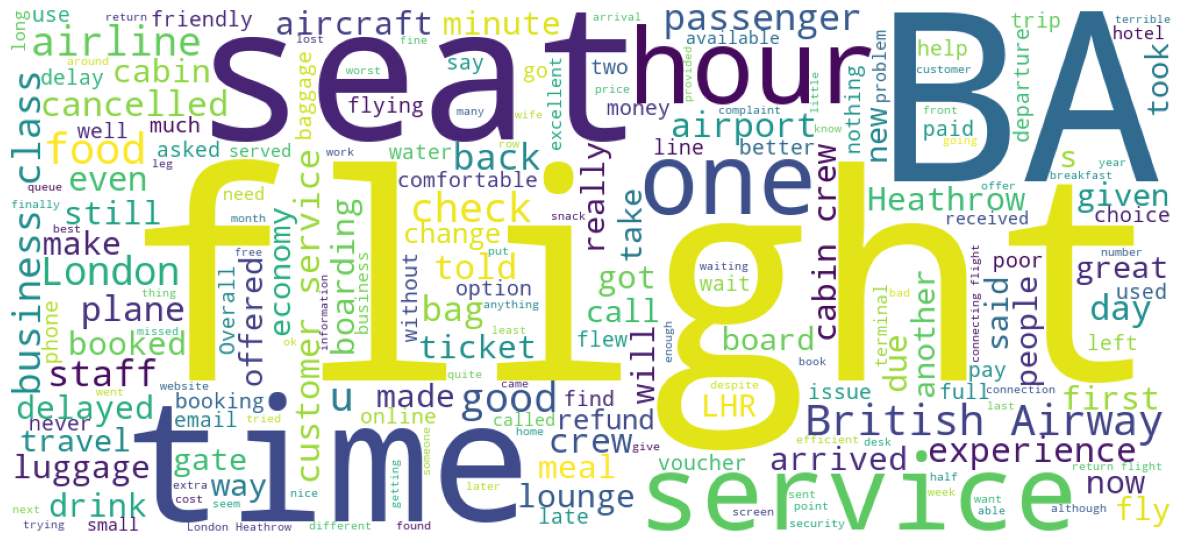

In [20]:
review_word = []

for i in df['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450, background_color = 'white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

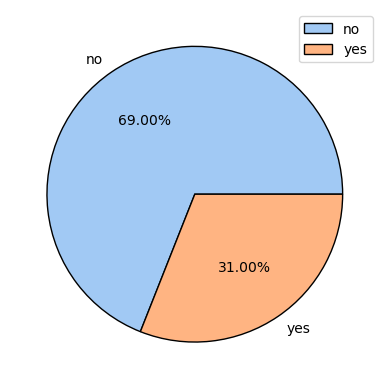

In [24]:
soc = df.groupby('Recommended')['reviews'].count().reset_index()
plt.pie(soc['reviews'], labels = soc['Recommended'], autopct='%.2f%%',colors = sns.color_palette('pastel'),
          wedgeprops={"edgecolor":"k"},)
plt.legend()
plt.show()

In [26]:
df_soc = df[df['Recommended'] == 'no']
df_soc.describe()

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Inflight Entertainment,Wifi & Connectivity
count,602.000000,592.000000,486.000000,633.000000,690.000000,339.000000,222.000000
mean,2.091362,2.418919,1.858025,1.761453,1.501449,2.185841,1.558559
std,1.111111,1.316374,1.069930,1.156284,0.810399,1.215399,0.990312
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [28]:
data = df_soc[df_soc['reviews'].str.contains('food | drink')]
data['reviews'].to_csv('test.csv')

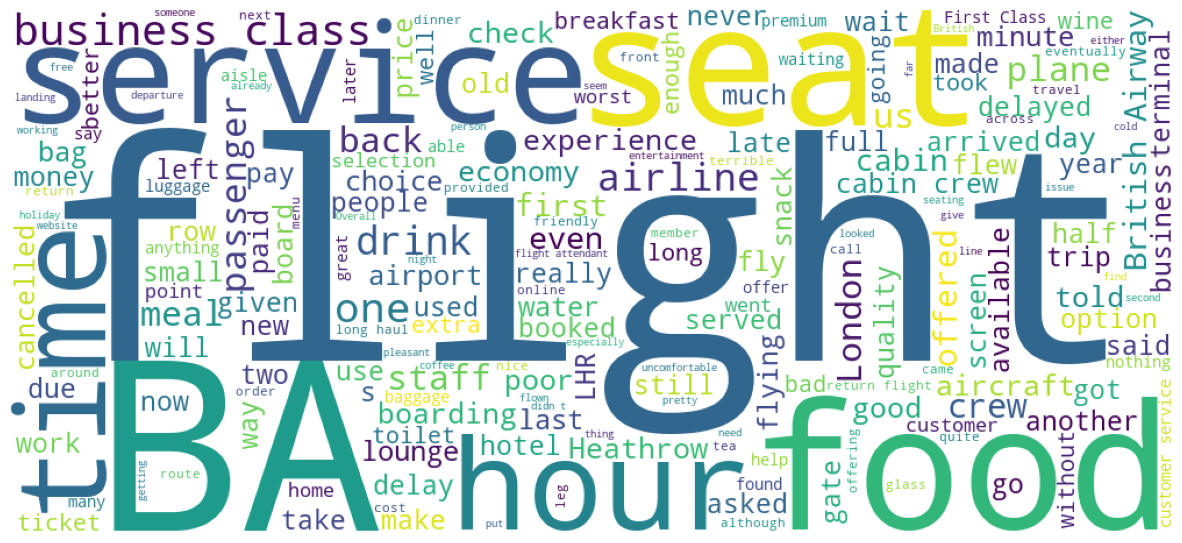

In [30]:
review_word = []

for i in data['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450, background_color = 'white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [32]:
data = df_soc[df_soc['reviews'].str.contains('money | refund & value')]
data['reviews'].to_csv('test2.csv')

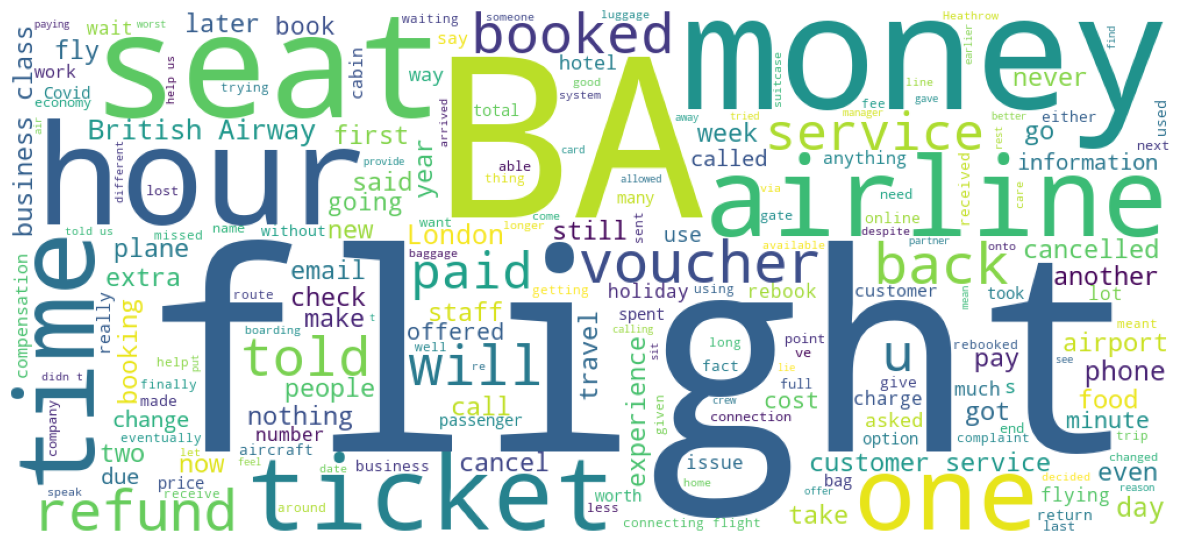

In [34]:
review_word = []

for i in data['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450, background_color = 'white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [38]:
from textblob import TextBlob

# Apply TextBlob sentiment analysis
df['sentiment'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Convert polarity scores into labels
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')


In [40]:
# Check the first few rows
print(df[['reviews', 'sentiment', 'sentiment_label']].head())


                                             reviews  sentiment  \
0   |   Disappointing service, plane interior and...  -0.092749   
1   |   A transit visa is required for my partner...  -0.012500   
2   |   I was surprised to receive confirmation p...   0.093687   
3   |   Flight cancelled, not refunding our money...  -0.056818   
4   |   I had visa issues, and hence, was debarre...   0.166364   

  sentiment_label  
0        negative  
1        negative  
2        positive  
3        negative  
4        positive  


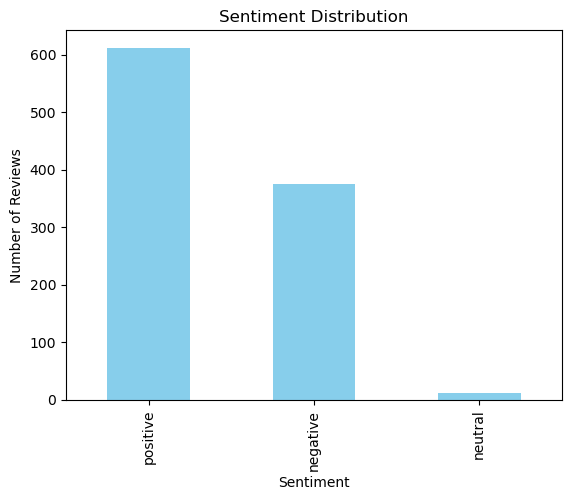

In [42]:
# Plot sentiment label distribution
df['sentiment_label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [46]:
# Set up CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['reviews'])

In [50]:
# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=0)

In [52]:
# Display the top 10 words for each topic
num_words = 10
for index, topic in enumerate(lda.components_):
    print(f"Topic #{index+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-num_words:]])


Topic #1:
['time', 'online', 'check', 'return', 'british', 'airways', 'airline', 'flights', 'flight', 'ba']
Topic #2:
['business', 'cabin', 'seat', 'ba', 'class', 'service', 'crew', 'food', 'good', 'flight']
Topic #3:
['seat', 'crew', 'staff', 'cabin', 'class', 'service', 'seats', 'business', 'flight', 'ba']
Topic #4:
['airport', 'ba', 'hours', 'london', 'told', 'service', 'airways', 'customer', 'british', 'flight']
Topic #5:
['gate', 'airport', 'london', 'hour', 'airline', 'staff', 'time', 'check', 'ba', 'flight']


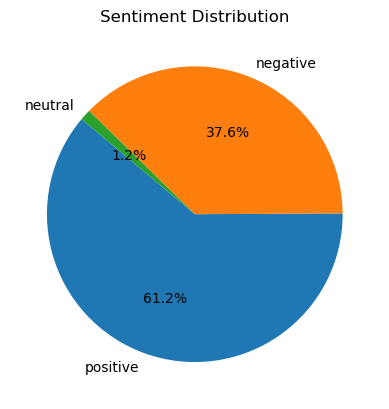

In [54]:
# Plot pie chart for sentiment distribution
sentiment_counts = df['sentiment_label'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

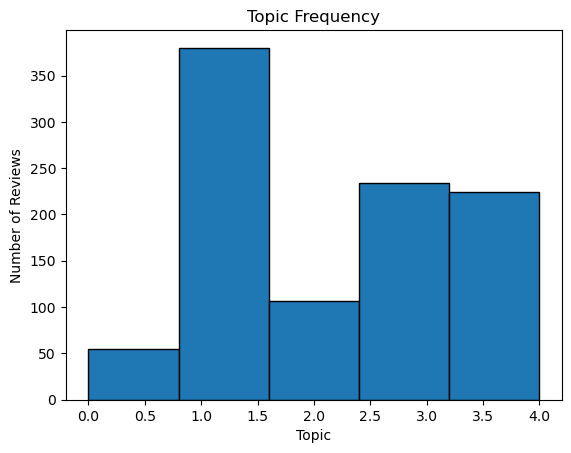

In [56]:
# Count the number of reviews assigned to each topic
topic_counts = lda.transform(X).argmax(axis=1)
plt.hist(topic_counts, bins=5, edgecolor='k')
plt.title('Topic Frequency')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()


In [58]:
print(df[df['sentiment_label'] == 'positive'].head())
print(df[df['sentiment_label'] == 'negative'].head())

         Aircraft Type Of Traveller        Seat Type  \
2            A320      Solo Leisure    Economy Class   
4             NaN      Solo Leisure  Premium Economy   
5  Boeing 777-300    Family Leisure   Business Class   
7            A380    Couple Leisure  Premium Economy   
8        A380-800    Family Leisure    Economy Class   

                            Route      Date Flown  Seat Comfort  \
2    Las Palmas to London Gatwick    October 2024           2.0   
4                Mumbai to London   November 2024           2.0   
5             Singapore to London   November 2024           5.0   
7              Heathrow to Boston  September 2024           2.0   
8  Los Angeles to London Heathrow   November 2024           3.0   

   Cabin Staff Service  Food & Beverages  Ground Service  Value For Money  \
2                  2.0               1.0             3.0                4   
4                  2.0               NaN             4.0                1   
5                  4.0       